In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import glob

from r2z.zmatrix import ZMatrix, pts_to_bond, pts_to_angle, pts_to_dihedral
from z_helpers import is_z_valid, calc_rmsd, calc_max, setLabels

from r2z import ureg

# 1.) Build the Z-Matrix Connectivity Table from a RDkit molecule

The first thing we want to accomplish is to build the Z-Matrix connectivity table from the molecular graph. But first we need a molecule, let's use diethyl ether.

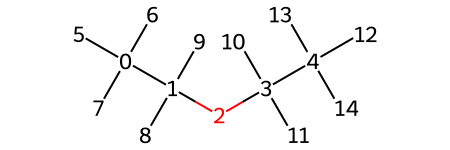

In [21]:
from rdkit.Chem.Draw import IPythonConsole

rdmol = Chem.MolFromSmiles("CCOCC")
rdmol = AllChem.AddHs(rdmol)
setLabels(rdmol)
rdmol.Compute2DCoords()
rdmol

Now we will initialize a ZMatrix instance using the rdkit molecule and print the connectivity table. The connectivity table is stored as a python dictionary. The keys are the indices (stored as int) of each atom in the Zmatrix going from the root atom down to the last atom. These indices correspond to the rows in the Z-Matrix. The values in the dictionary are a list of atom indices (stored as int) that define that particular atom in the zmatrix but according to the numbering of the rdkit molecule object (yes, these do not have the same numbering/ordering!). The first item in that dictionary is the atom itself, the second is the atom it is bonded it, the third is the atom it has an angle with and the fourth is the atom it has an dihedral angle with.

In [22]:
zm = ZMatrix(rdmol)
print(zm.z)

{0: [0], 1: [1, 0], 2: [2, 1, 0], 3: [3, 2, 1, 0], 4: [10, 3, 2, 1], 5: [11, 3, 2, 1], 6: [4, 3, 2, 1], 7: [12, 4, 3, 2], 8: [13, 4, 3, 2], 9: [14, 4, 3, 2], 10: [8, 1, 2, 3], 11: [9, 1, 2, 3], 12: [5, 0, 1, 2], 13: [6, 0, 1, 2], 14: [7, 0, 1, 2]}


But we can also get the Z-Matrix connectivity table in the ordering of the Z-Matrix.

In [23]:
print(zm.zz)

{0: [0], 1: [1, 0], 2: [2, 1, 0], 3: [3, 2, 1, 0], 4: [4, 3, 2, 1], 5: [5, 3, 2, 1], 6: [6, 3, 2, 1], 7: [7, 6, 3, 2], 8: [8, 6, 3, 2], 9: [9, 6, 3, 2], 10: [10, 1, 2, 3], 11: [11, 1, 2, 3], 12: [12, 0, 1, 2], 13: [13, 0, 1, 2], 14: [14, 0, 1, 2]}


# 2.) Coordinate transformations

Now we want to transform a Molecule in Cartesian coordinates to ZMatrix coordinates (i.e. to internal coordinates). This can easily be accomplished with our ZMatrix class. But first we must generate some Cartesian coordinates for our molecule. Note that we will use `unit` from the `simtk` package in order enfore correct units on all coordinates, bond lengths and angles during all conversions (it is easy to get lost here!).

In [24]:
AllChem.EmbedMolecule(rdmol)
AllChem.MMFFOptimizeMolecule(rdmol)
cart_crds = np.array(rdmol.GetConformers()[0].GetPositions())*ureg.angstrom
cart_crds

Magnitude,[[2.237812020749655 0.6753181629342783 -0.7206903012998817] [1.2502442737112458 -0.21381541029915735 0.008339988835787744] [-0.06713363876477395 0.25821538754450574 -0.2632752094955727] [-1.0563281092192949 -0.5320694386635143 0.39171819831334226] [-2.421801800495048 0.032383372667838216 0.05376986092815379] [2.1350704019518285 1.715200395809824 -0.393280059023075] [3.2653680911248046 0.34793385055025416 -0.5394362474781603] [2.046988764365299 0.6605425842600509 -1.7988719490594354] [1.441577257615921 -0.17712517039348705 1.0864020370342486] [1.3521776837961426 -1.2474449798939637 -0.3400719598813067] [-0.9872988627537799 -1.5702442635079767 0.048792210648293886] [-0.897890582906162 -0.4999008903676492 1.475245998519547] [-2.4984133835682947 1.0758755172139178 0.3768208848649275] [-2.586520861613256 0.02119456782460582 -1.0287498214588067] [-3.2138512539943473 -0.5460636856794805 0.537463958950189]]
Units,angstrom


## 2.1.) Cartesian to ZMatrix

Now that we have Cartesian coordinates, transform them into ZMatrix coordinates according to ZMatrix connectivity table. The ZMatrix coordinates will be stored as a dictionary, where the keys are the rows in the ZMatrix (a.k.a atom indices according to the numbering in the ZMatrix connectivity table) and the values are the bond lengths, angles and dihedral angles. Note that the first atom will have the original Cartesian coordinates as its value in the dictionary.

In [25]:
z_crds = zm.build_z_crds(cart_crds)
z_crds

{0: [array([ 0.2237812 ,  0.06753182, -0.07206903]) <Unit('nanometer')>],
 1: [0.15156957907102184 <Unit('nanometer')>],
 2: [0.1425507788248519 <Unit('nanometer')>,
  108.43586163951508 <Unit('degree')>],
 3: [0.14255076889254492 <Unit('nanometer')>,
  111.72567091974432 <Unit('degree')>,
  -179.99896985142217 <Unit('degree')>],
 4: [0.10955228143788133 <Unit('nanometer')>,
  109.74375160268161 <Unit('degree')>,
  -59.98081856508696 <Unit('degree')>],
 5: [0.10955225963271525 <Unit('nanometer')>,
  109.74373717770344 <Unit('degree')>,
  59.98101805347823 <Unit('degree')>],
 6: [0.15156960303858788 <Unit('nanometer')>,
  108.43588230304034 <Unit('degree')>,
  179.99996438627758 <Unit('degree')>],
 7: [0.10950375128081061 <Unit('nanometer')>,
  110.61739125731737 <Unit('degree')>,
  -59.13267669444621 <Unit('degree')>],
 8: [0.10950371780011167 <Unit('nanometer')>,
  110.61743840524149 <Unit('degree')>,
  59.13332537411272 <Unit('degree')>],
 9: [0.10935736447814365 <Unit('nanometer')>,

## 2.2.) Z-Matrix to Cartesian

From the ZMatrix coordinates, one can also transform back to Cartesian space. However, this requires us to define a reference coordinate system. This is necessary, since the ZMatrix coordinates are only defined through internal coordinates starting at the root atom. Thus, these coordinates do not require an external coordinate system. However, if we want to transfer the ZMatrix coordinates back to Cartesian coordinates, we must pick a set of three reference points (i.e. a plane) in Cartesian space and then another set of internal coordinates with respect to these three reference points that informs the correct translation/rotation with respect to these reference points. These reference points are also called virtual coordinates. 

Assume we have a molecule with 5 atoms `A-B-C-D-E`. Also assume we have ZMatrix for that molecule. The three reference points we are: `X`,`Y` and `Z`. Also, we want three torsion angles for `X-Y-Z-A`, `Y-Z-A-B`, `Z-A-B-C`, two angles `Y-Z-A`, `Z-A-B` and the bond length `Z-A`.

The transformation to Cartesian coordinates is accomplished as follows:

In [26]:
### Our reference points are just the coordinate axis in the lab frame
ref       = np.eye(3)*ureg.angstrom

### Next, build the virtual coordinates.
### First, one bond length
virtual_bond   = pts_to_bond(ref[:,2], cart_crds[zm.z[0][0]])
### Second, two angles
virtual_angles = [pts_to_angle(ref[:,1], ref[:,2], cart_crds[zm.z[0][0]]),
                  pts_to_angle(ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]])]
### Third, three dihedrals
virtual_dihedrals = [pts_to_dihedral(ref[:,0], ref[:,1], ref[:,2], cart_crds[zm.z[0][0]]),
                     pts_to_dihedral(ref[:,1], ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]]),
                     pts_to_dihedral(ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]], cart_crds[zm.z[2][0]])]

### Freed the ZMatrix coordinates with the virtual coordinates into the
### the ZMatrix object
cart_from_z = zm.build_cart_crds(z_crds, virtual_bond, 
                                 virtual_angles, virtual_dihedrals, ref)
cart_from_z.to(ureg.angstrom)

Magnitude,[[2.2378120207496552 0.6753181629342782 -0.7206903012998804] [1.2502442737112462 -0.2138154102991574 0.008339988835788237] [-0.06713363876477335 0.25821538754450474 -0.2632752094955726] [-1.0563281092194288 -0.53206943866513 0.3917181983111903] [-2.4218018004850994 0.03238337278691952 0.05376986108685637] [2.1350704019518285 1.7152003958098239 -0.39328005902307406] [3.265368091125077 0.34793385055350484 -0.539436247473827] [2.0469887643653 0.6605425842600507 -1.798871949059434] [1.4415772576151809 -0.1771251703954392 1.086402037034447] [1.3521776837967792 -1.2474449798932692 -0.3400719598831804] [-0.9872988627532798 -1.570244263508921 0.048792210644237194] [-0.8978905829070385 -0.4999008903712402 1.4752459985175626] [-2.4984133834668296 1.075875517305923 0.37682088513279194] [-2.5865208616872586 0.02119456806134623 -1.0287498212885458] [-3.213851253983331 -0.5460636855476192 0.5374639591259243]]
Units,angstrom


Let's check how much they differ from the original coordinates (not much).

In [27]:
rmsd = calc_rmsd(cart_from_z, cart_crds)
max_diff = calc_max(cart_from_z, cart_crds)
print(f'RMSD: {rmsd}; MAX-DIFF {max_diff}')

RMSD: 7.731045939791728e-11 angstrom; MAX-DIFF 2.6786445284088245e-10 angstrom


# 3.) Pretty ZMatrix for QC codes

Zmatrix coordinates can be used as input for Quantum Chemistry codes. A string with nicely formated ZMatrix coordinates can be generated by our ZMatrix class.

In [28]:
z_string  = zm.build_pretty_zcrds(cart_crds)
print(z_string)

C 
C 1 1.5157 
O 2 1.4255 1 108.4359 
C 3 1.4255 2 111.7257 1 -179.9990 
H 4 1.0955 3 109.7438 2 -59.9808 
H 4 1.0955 3 109.7437 2 59.9810 
C 4 1.5157 3 108.4359 2 180.0000 
H 7 1.0950 4 110.6174 3 -59.1327 
H 7 1.0950 4 110.6174 3 59.1333 
H 7 1.0936 4 110.9093 3 -179.9995 
H 2 1.0955 3 109.7438 4 -59.9800 
H 2 1.0955 3 109.7437 4 59.9819 
H 1 1.0950 2 110.6174 3 59.1327 
H 1 1.0936 2 110.9093 3 179.9997 
H 1 1.0950 2 110.6174 3 -59.1333 


With that it is very convenient to parse the coordinates to PSI4 out to carry out an optimization.

In [ ]:
### The following line installs psi4, which is needed for the QC optimization
!conda install -c psi4 psi4

In [ ]:
import psi4

charge = Chem.rdmolops.GetFormalCharge(rdmol)
psi4.set_memory('500 MB')
psi4.set_num_threads(1)
psi4.set_options({'geom_maxiter': 100})
psi4.set_options({'g_convergence': 'gau_tight'})

psi4mol   = psi4.geometry(f"""
{charge} 1
{z_string}
""")
E, wfn = psi4.optimize('pbe0/def2-svp',
                        molecule=psi4mol,
                        return_wfn=True)
print(E)

# 4.) Error Assessment

Next, we want to generate Cartesian coordintes and transform them back and forth in order to see how the transformations affect the accuracy of the coordinates. First, let's try some drug-like molecules from the Enamine REAL database.

In addition to assessing coordinate accuracy, we check if each ZMatrix is actually valid, i.e. want to check if each row in the ZMatrix of a given molecule was defined *only* through atoms that were already defined in a prior row of the same ZMatrix.

In [ ]:
for smifile in glob.glob("./data/real/*.smiles"):
    with open(smifile, "r") as fopen:
        lines = fopen.readlines()
        for line in lines:
            ### Generate an rdkit molecule (at this point there are no Cartesian coordinates!)
            smi   = line.rstrip().lstrip().split()[0]
            rdmol = Chem.MolFromSmiles(smi)
            rdmol = Chem.AddHs(rdmol)
            ### Generate the ZMatrix instance (builds the Zmatrix connectivity table).
            zm    = ZMatrix(rdmol)
            print(f"{smi} ", end=" ")
            ### Check if the ZMatrix is valid
            if not is_z_valid(zm, rdmol):
                print(f'Z-valid?: No; RMSD: NA; MAX-DIFF NA')
                continue
            ### Generate Cartesian and ZMatrix coordinates
            AllChem.EmbedMolecule(rdmol)
            AllChem.MMFFOptimizeMolecule(rdmol)
            cart_crds = np.array(rdmol.GetConformers()[0].GetPositions())*ureg.angstrom
            z_crds    = zm.build_z_crds(cart_crds)

            ### Compute virtual coordinates
            ref = np.eye(3)*ureg.nanometer
            virtual_bond   = pts_to_bond(ref[:,2], cart_crds[zm.z[0][0]])
            virtual_angles = [pts_to_angle(ref[:,1], ref[:,2], cart_crds[zm.z[0][0]]),
                              pts_to_angle(ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]])]
            virtual_dihedrals = [pts_to_dihedral(ref[:,0], ref[:,1], ref[:,2], cart_crds[zm.z[0][0]]),
                                 pts_to_dihedral(ref[:,1], ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]]),
                                 pts_to_dihedral(ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]], cart_crds[zm.z[2][0]])]
            
            ### Transform back to Cartesian space 
            cart_from_z = zm.build_cart_crds(z_crds, virtual_bond, 
                                             virtual_angles, virtual_dihedrals, ref)
            rmsd = calc_rmsd(cart_from_z, cart_crds)
            max_diff = calc_max(cart_from_z, cart_crds)
            print(f'Z-valid?: Yes; RMSD: {rmsd:4.2f}; MAX-DIFF {max_diff:4.2f}')

Next, look at a host guest complexes. In this example we want to use the host in order to define the virtual coordinates of the guest.

In [ ]:
### Load molecules (they already have Cartesian coordinates)
mol2path_host  = "./data/host-guest/host.mol2"
mol2path_guest = "./data/host-guest/guest.mol2"
rdmol_host  = Chem.MolFromMol2File(mol2path_host)
rdmol_host  = Chem.AddHs(rdmol_host)
rdmol_guest = Chem.MolFromMol2File(mol2path_guest)
rdmol_guest = Chem.AddHs(rdmol_guest)

crds_host = np.array(rdmol_host.GetConformers()[0].GetPositions())*ureg.angstrom
cart_crds = np.array(rdmol_guest.GetConformers()[0].GetPositions())*ureg.angstrom

### Build Zmatrix coordinates guest molecule
zm          = ZMatrix(rdmol_guest)
if not is_z_valid(zm, rdmol_guest):
    print(f'Z-valid?: No; RMSD: NA; MAX-DIFF NA')
z_crds    = zm.build_z_crds(cart_crds)

### Generate the Cartesian coordinates using the host molecule as a reference
### We could use any three (not co-linear) atom coordinates of the host. Let's
### just use the first three.
ref            = crds_host[:3,]
virtual_bond   = pts_to_bond(ref[:,2], cart_crds[zm.z[0][0]])
virtual_angles = [pts_to_angle(ref[:,1], ref[:,2], cart_crds[zm.z[0][0]]),
                  pts_to_angle(ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]])]
virtual_dihedrals = [pts_to_dihedral(ref[:,0], ref[:,1], ref[:,2], cart_crds[zm.z[0][0]]),
                     pts_to_dihedral(ref[:,1], ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]]),
                     pts_to_dihedral(ref[:,2], cart_crds[zm.z[0][0]], cart_crds[zm.z[1][0]], cart_crds[zm.z[2][0]])]
cart_from_z = zm.build_cart_crds(z_crds, virtual_bond, 
                                 virtual_angles, virtual_dihedrals, ref)
rmsd = calc_rmsd(cart_from_z, cart_crds)
max_diff = calc_max(cart_from_z, cart_crds)
print(f'Z-valid?: Yes; RMSD: {rmsd}; MAX-DIFF {max_diff}')